# Bibliothèques

##### Pour faire fonctionner les widgets, il est nécessaire d'installer le package ipywidgets via : pip install ipywidgets
#### puis d'utiliser la commande : jupyter nbextension enable --py widgetsnbextension

In [130]:
%matplotlib inline

## Modules de calcul
import numpy as np
from numpy.matlib import repmat
import pandas as pd
from tqdm import tqdm

## Modules graphiques
import matplotlib.pyplot as plt
import seaborn
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
init_notebook_mode(connected=True)
import plotly.offline as py
import plotly.graph_objs as go
import seaborn as sns
sns.set(color_codes=True)
from IPython.html.widgets  import widgets, interact
from IPython.display import display, clear_output
import colorlover as cl
from termcolor import colored

## Fichiers locaux
from tools import *


# Fonctions et classes annexes :

In [2]:
def figure_size(width, height):
    """ Allow to choose the size of scatter plot """

    # Get current size
    fig_size = plt.rcParams["figure.figsize"]

    # Set figure width to 12 and height to 9
    fig_size[0] = width
    fig_size[1] = height
    plt.rcParams["figure.figsize"] = fig_size
    
    return 

In [210]:
class Perceptron:
    def __init__(self,max_iter = 100,eps=1e-3,projection = None):
        self.max_iter = max_iter
        self.eps = eps
        self.projection = projection or (lambda x: x) #projection fonction identite par default

    def fit(self, data, y, k=1, GD_mode=0, eps_mode=0, winit=[], informations=True):
        data = self.projection(data)
        if len(winit) == 0 :
            self.w = np.random.random((1,data.shape[1]))
        else :
            self.w = winit
        self.winit = self.w.copy()
        self.histo_w  = np.zeros((self.max_iter,data.shape[1]))
        self.histo_f = np.zeros((self.max_iter,1))
        ylab=set(y.flat)
        if len(ylab) != 2:
            print("pas bon nombres de labels (%d)" % (ylab,))
            return
        
        self.labels = {-1: min(ylab), 1:max(ylab)}
        y = 2*(y!=self.labels[-1])-1
        
        if informations : print("Itérations de l'algorithme d'apprentissage ... \n")
        self.gradient_decent(data, y, k=k, GD_mode=GD_mode, max_iter=self.max_iter, 
                             eps_mode=eps_mode, informations=informations)
            
    def predict(self,data):
        data = self.projection(data)
        return np.array([self.labels[x] for x in np.sign(data.dot(self.w.T)).flat]).reshape((len(data),))
    
    def score(self,data,y):
        return np.mean(self.predict(data)==y)
    
    def predict_w(self, data, w):
        data = self.projection(data)
        return np.array([self.labels[x] for x in np.sign(data.dot(w.T)).flat]).reshape((len(data),))
    
    def score_w(self, data, y, w):
        return np.mean(self.predict_w(data, w)==y)

    def get_eps(self, ite=1, eps_mode=0):
        if eps_mode == 0:
            return self.eps
        if eps_mode >= 1:
            return 1/((ite+1)**eps_mode)
   
    def loss(self,data,y):
        return hinge(self.w,data,y)
    
    def loss_g(self,data,y):
        return grad_hinge(self.w,data,y)
    
    def errors(self, data, y, legend=None):
        iterations = np.arange(self.max_iter)
        erreurs = []
        data = self.projection(data)
        for it in iterations:
            erreurs.append(1 - self.score_w(data, y,self.histo_w[it]))
        plt.plot(iterations, erreurs, label=legend)
        plt.xlabel("Nombre d'itérations")
        plt.ylabel("Erreur")
    
    def gradient_decent(self, data, y, k=1, GD_mode=0, max_iter=50, 
                        eps_mode=0, informations=True):
        
        n, d = np.shape(data)
        idx = range(n)
        ite = 0
        
        ## Batch Gradient Descent
        if GD_mode == 0:
            while ite<self.max_iter:
                for j in idx:
                    self.w = self.w - self.get_eps(ite=ite, eps_mode=eps_mode)*self.loss_g(data[j],y[j:(j+1)])
                self.histo_w[ite] = self.w
                self.histo_f[ite] = self.loss(data,y)
                if ite % 20==0 and informations: print(ite,self.histo_f[ite])
                ite+=1
            
        ## Stochastic descent
        if GD_mode == 1:
            while ite<self.max_iter:
                idx = np.random.permutation(idx)
                data = data[idx]
                y = y[idx]
                for i in range(n):
                    j = np.random.randint(0,n)
                    self.w = self.w - self.get_eps(ite=ite, eps_mode=eps_mode)*self.loss_g(data[j],y[j:(j+1)])
                self.histo_w[ite] = self.w
                self.histo_f[ite] = self.loss(data,y)
                if ite % 20==0 and informations: print(ite,self.histo_f[ite])
                ite+=1
            
        ## Mini-batch
        if GD_mode == 2:
            while ite<self.max_iter:
                idx = np.random.permutation(idx)
                data = data[idx]
                y = y[idx]
                pas = int(n/k)
                for j in range(k+1):                     
                    for v in range(pas):
                        if j == k and n-1 > k*pas:
                            i = np.random.randint(j*pas,n-1)
                        elif j == k :
                            continue
                        else :
                            i = np.random.randint(j*pas,(j+1)*pas)
                        self.w = self.w - self.get_eps(ite=ite, eps_mode=eps_mode)*self.loss_g(data[i],y[i:(i+1)])
                self.histo_w[ite] = self.w
                self.histo_f[ite] = self.loss(data,y)
                if ite % 20==0 and informations: print(ite,self.histo_f[ite])
                ite+=1

# Question 1 : Implémentation du perceptron

## Question 1.1 :

In [67]:
def hinge(w, data, y):
    data,y,w=data.reshape(len(y),-1),y.reshape(-1,1),w.reshape(1,-1)
    res = -y*(np.dot(data, w.T))
    res[res < 0] = 0
    return res.mean()

def grad_hinge(w, data, y):
    data,y,w=data.reshape(len(y),-1),y.reshape(-1,1),w.reshape(1,-1)
    l, col = np.shape(data)
    grad = -y*data
    res = -y*(np.dot(data, w.T))
    res = repmat(res, 1, col)
    grad = np.where(res<0, 0, grad)
    return grad.mean(axis=0)

#### Test des fonctions hinge, grad_hinge

In [68]:
w = np.random.random((3,))
data = np.random.random((100,3))
y = np.random.randint(0,2,size = (100,1))*2-1
print(hinge(w,data,y), hinge(w,data[0],y[0]), hinge(w,data[0,:],y[0]))
print(grad_hinge(w,data,y),grad_hinge(w,data[0],y[0]).shape,grad_hinge(w,data[0,:],y[0]).shape)

0.381861330823 0.0 0.0
[ 0.27675688  0.26868492  0.24174134] (3,) (3,)


## Question 1.2 :

In [69]:
def question12(data_type=0, epsilon=0.3, eps=1e-3):

    ### Generation de donnees
    xtrain,ytrain = gen_arti(data_type=data_type,epsilon=epsilon)
    xtest,ytest = gen_arti(data_type=data_type,epsilon=epsilon)

    plt.ion()

    ### Apprentissage
    model= Perceptron(eps=eps)
    model.fit(xtrain,ytrain)
    
    ### Scores
    print("\nScore sur les données d'apprentissage : ",model.score(xtrain,ytrain))
    print("Score sur les données de test : ",model.score(xtest,ytest))
    
    #### Tracer de la frontiere
    plt.figure()
    plot_frontiere(xtrain,model.predict,50)
    plot_data(xtrain,ytrain)
    plt.xlabel('X', fontsize=15)
    plt.ylabel('Y', fontsize=15)
    plt.title("Données d'apprentissage et Frontière prédite", fontsize=15)

Itérations de l'algorithme d'apprentissage ... 

0 [ 0.]
20 [ 0.]
40 [ 0.]
60 [ 0.]
80 [ 0.]

Score sur les données d'apprentissage :  1.0
Score sur les données de test :  0.999


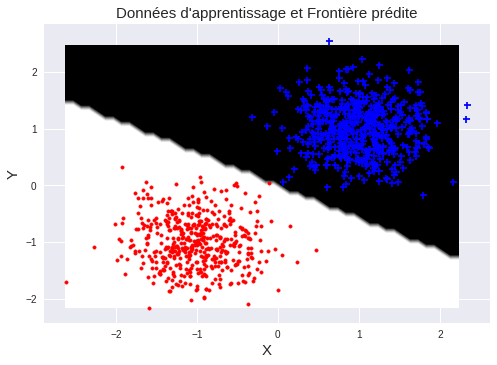

In [70]:
question12()

## Question 1.3 :

In [71]:
## Représentation de la trajectoire de w

def surface_3D(fonc, w1min=-1.1, w1max=1.1, w2min=-1.1, w2max=1.1, 
               colorscale='Viridis'):

    ### Surface de la fonction de perte
    w1 = np.linspace(w1min,w1max,num=40)
    w2 = np.linspace(w2min,w2max,num=40)
    fw = np.array([[fonc(np.array([xi,yi])) for yi in w2] for xi in w1])
    
    data_f = pd.DataFrame(data=fw)

    trace1 = go.Surface(
        x = w1,
        y = w2,
        z = data_f.as_matrix(),
        opacity=0.9,
        colorscale=colorscale,
        name = "Hinge loss"
    )
    
    return trace1

In [72]:
def slider_3D(ite, x_histo, f_histo, trace1, fig=None, w=5, h=5):
    
    clear_output()
    fig.clf()
    fig = plt.figure()
    data = [trace1]
    
    ### Représentation des itérations de descente :
    xs = x_histo[:ite,0].reshape(-1)
    ys = x_histo[:ite,1].reshape(-1)
    zs = f_histo[:ite].reshape(-1)

    trace2 = go.Scatter3d(
        x=xs,
        y=ys,
        z=zs,
        marker=dict(
            size=5,
            color='rgb(200, 0, 0)', # set color to an array/list of desired values   # choose a colorscale
            opacity=4,
        ),
        line=dict(
            color='rgb(200, 0, 0)',
            width=2
        ),
    )

    data.append(trace2)

    layout = dict(margin=go.Margin(
                        l=0,
                        r=0,
                        b=0,
                        t=0,
                    ),
                  scene = dict(
                        xaxis = dict(
                            title='w1'),
                        yaxis = dict(
                            title='w2'),
                    ), 
                 )

    fig = dict(data=data, layout=layout)
    py.iplot(fig)

In [73]:
def slider_heatmap(ite, f, model, w1min=-1.1, w1max=1.1, w2min=-1.1, 
                   w2max=1.1, nb=100, w=5, h=5):
    
    ### Données à afficher
    w1_x = np.linspace(w1min,w1max,num=nb)
    w2_y = np.linspace(w2min,w2max,num=nb)
    pdf = np.array([[f(np.array([w2_y[-1-i],w1_x[j]])) for j in range(nb)] for i in range(nb)])
    w1_hist = nb/2*(model.histo_w[:, 0]) + nb/2
    w2_hist = nb/2*(model.histo_w[:, 1]) + nb/2
    
    ### Valeurs des poids
    print("Valeur initiale des poids :", model.histo_w[0, :])
    print("Valeur finale des poids :", model.histo_w[-1, :])
    
    ### Heatmap 
    plt.figure()
    ax = sns.heatmap(pdf.T, cmap="Spectral_r", square=True,
                     xticklabels=False, yticklabels=False)
    plt.scatter(w1_hist[:ite+1], w2_hist[:ite+1], alpha=0.6, 
                color="red")
    plt.grid()
    plt.xlabel('W1', fontsize=15)
    plt.ylabel('W2', fontsize=15)
    plt.title("Trajectoire de l'apprentissage dans l'espace des poids \n", 
              fontsize=15)
    plt.show()

In [74]:
def question13(display_mode=1, GD_mode=0, k=1, eps_mode=0, 
               eps=1e-3, max_iter=50, centerx=1, sigma=0.1, nbex=1000,
               data_type=0, epsilon=0.02, w2min=-3, w2max=3, 
               winit=[], w=8, h=8):

    fig1 = plt.figure()
    
    ### Données artificielles:
    xtrain, ytrain = gen_arti(centerx=centerx, sigma=sigma, nbex=nbex,
                              data_type=data_type, epsilon=epsilon)
    
    f = lambda w : hinge(w, xtrain, ytrain)

    ### Compute of the model
    model = Perceptron(eps=1e-3, max_iter=max_iter)
    model.fit(xtrain,ytrain, k=k, GD_mode=GD_mode,eps_mode=eps_mode,
              winit=winit)
    
    ### Compute of the colorscale
    cls=[[0, 'rgb(0,0,131)'], [0.0075, 'rgb(0,60,170)'],
         [0.125, 'rgb(5,255,255)'], [0.325, 'rgb(255,255,0)'],
         [0.575, 'rgb(250,0,0)'], [1, 'rgb(128,0,0)']]

    ### 3D graphic
    trace1 = surface_3D(f, colorscale=cls)
    
    s1 = lambda ite: slider_3D(ite, model.histo_w, model.histo_f, 
                               trace1, fig=fig1, w=w, h=h)

    ### 2D graphic
    s2 = lambda ite : slider_heatmap(ite, f, model, w=w, h=h)
    
    if display_mode==1 :
        res = interact(s1, ite=widgets.IntSlider(min=0,max=max_iter,
                                                 step=2,value=0))
    if display_mode==2 :
        res = interact(s2, ite=widgets.IntSlider(min=0,max=max_iter,
                                                 step=2,value=0))
    
    print("\n Valeur Finale des W: ", model.histo_w[-1])
    
    #### Tracer de la frontiere
    plt.figure()
    plot_frontiere(xtrain,model.predict,50)
    plot_data(xtrain,ytrain)
    plt.xlabel('X', fontsize=15)
    plt.ylabel('Y', fontsize=15)
    plt.title("Données d'apprentissage et Frontière pr", fontsize=15)  

#### Cas des données non bruitées :

-----------------------------------------------------------------------

Itérations de l'algorithme d'apprentissage ... 

0 [ 0.]
20 [ 0.]
40 [ 0.]



 Valeur Finale des W:  [ 0.29212793  0.06311458]


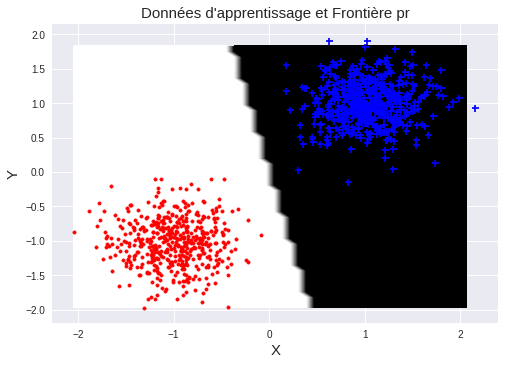

In [75]:
question13(display_mode=1)

Itérations de l'algorithme d'apprentissage ... 

0 [ 0.]
20 [ 0.]
40 [ 0.]



 Valeur Finale des W:  [ 0.25516219  0.28399124]


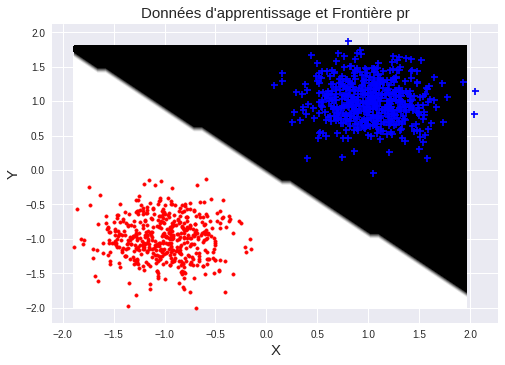

In [76]:
question13(display_mode=2)

#### Commentaire :

* Dans le cas où les données sont séparables :

Il existe bien évidemment plusieurs solutions pour l'équation de la frontière. Pour s'en convaincre, on peut remarquer qu'une infinité de tracé de frontière sont possibles sur le graphe ci-dessus. De plus, on remarque qu'expérimentalement, le graphe 3D semble assurer du fait qu'on est bien une infinité de solutions, puisqu'il existe tout un demi plan où la fonction de perte est minimale.

#### Cas des données non bruitées :

-----------------------------------------------------------------------

Itérations de l'algorithme d'apprentissage ... 

0 [ 0.11178761]
20 [ 0.00049421]
40 [ 0.00052477]



 Valeur Finale des W:  [ 0.00074894  0.00172896]


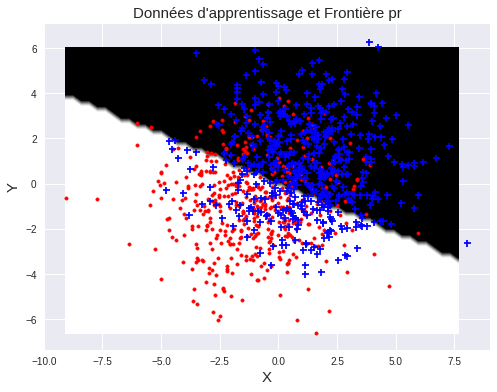

In [186]:
question13(display_mode=1, epsilon=2)

#### Commentaire :

* Dans le cas où les données ne sont pas séparables :

La fonction que l'on minise (la "Hinge Loss") ne possède pas de propriété de convexité forte  ou stricte. Nous ne sommes donc pas en mesure d'assurer l'unicité. Cependant, au vu du graphique 3D, il semble que la fonction admet bien un optimum global. Il semble donc qu'expérimentalement, il existe bien un unique optimum global et donc il existerait une solution pour la frontière unique.

## Question 1.4 :

Pour voir l'implémentation des techniques de descente de gradient, il faut se reporter au début du fichier et regarder la méthode "descent_gradient" implémentée dans la classe "Perceptron".

In [164]:
def slider_epsilon(epsilon, k=10, eps_mode=0, eps=1e-3, 
                   max_iter=50, centerx=1, sigma=1, nbex=1000, 
                   data_type=0, w2min=-3, w2max=3, w=10, h=15):
    
    GD_names=["Descente Batch",
              "Descente Stochastique", "Descente Mini-Batch"]
    
    winit = np.random.random((1,2))
    
    ### Données artificielles:
    xtrain, ytrain = gen_arti(centerx=centerx, sigma=sigma, nbex=nbex,
                              data_type=data_type, epsilon=epsilon) 
    
    ### Compute of the model
    model = Perceptron(eps=1e-3, max_iter=max_iter)
    iterations = range(max_iter)
    
    ### Compute the convergence :
    figure_size(w,h)
    plt.figure()
    for m in tqdm(range(3)):
        
        
        model.fit(xtrain,ytrain, k=k, GD_mode=m, eps_mode=eps_mode,
                  winit=winit, informations=False)
        
        fs = model.histo_f
        
        plt.plot(iterations, fs, label=GD_names[m])
        plt.xlabel('Itérations', fontsize=15)
        plt.ylabel("Fonction de coût", fontsize=15)
        plt.title("Convergence en fonction de la méthode de descente utilisée et pour un bruit égale à {}".format(epsilon), 
                 fontsize=15)
        plt.legend()  
        
    plt.show()
    
    #### Tracer de la frontiere
    plt.figure()
    plot_frontiere(xtrain,model.predict,50)
    plot_data(xtrain,ytrain)
    plt.xlabel('X', fontsize=15)
    plt.ylabel('Y', fontsize=15)
    plt.title("Données d'apprentissage et Frontière prédite pour un bruit de {}".format(epsilon), fontsize=15) 
    plt.show()

In [194]:
def question14(eps_mode, k=10, eps=1e-3, max_iter=50, centerx=1, 
               sigma=0.1, nbex=1000, data_type=0, w2min=-3, w2max=3, 
               step=100, w=8, h=6) :
    
    s_epsilon = lambda epsilon : slider_epsilon(epsilon/step, k=k, 
                                                eps_mode=eps_mode, 
                                                eps=eps, 
                                                max_iter=max_iter, 
                                                centerx=centerx,
                                                sigma=sigma, nbex=nbex, 
                                                data_type=data_type, 
                                                w2min=w2min, 
                                                w2max=w2max, w=w, h=h)
    
    res = interact(s_epsilon, epsilon=widgets.IntSlider(min=1,max=261,
                                                 step=40,value=0))   

In [195]:
question14(eps_mode=0)

#### Commentaire :

Avant toute chose, il est bon ton de rappeler que nous avons considéré des données artificielles séparables dans le cas où le bruit est nul (ie la variance est faible et les centres des gaussiennes sont éloignés). 

##### - Influence de la méthode de descente sur la vitesse de convergence :

On peut d'ores et déjà constaté que les trois méthodes produisent des résultats très similaires dans leur vitesse de convergence et ce peu importe le bruit. Nous remarquerons seulement que la descente stochastique est en général irrégulière du fait de sa nature aléatoire. De même la méthode par "mini-batch" est en général la plus performante. Dans la suite des remarques, nous ne ferons plus la distinction entre ces trois méthodes.

#####  - Influence du bruit sur la convergence :

Lorsque le bruit est extrêment faible, où nul, on constate souvent que dès la première itérations, nous avons une solution optimale. Ceci est lié au choix du paramètre initial.

Lorsque le bruit est très grand (supérieur ou égale à 1.5), on constate de la même manière que la convergence se produit de manière très rapide. En effet, on constate que la convergence vers une solution optimale se produit en moins de 10 itérations. 

Lorsque le bruit est compris entre ces deux régimes, on constate que le nombre d'itérations nécessaires à la convergence se réduit à mesure que le bruit augmente. En effet, on peut constater que lorsque le bruit est proche de $0.40$, aucune des méthode de descente de gradient ne parvient à converger. Ceci semble logique avec les constatations précédentes. En effet, comme nous avons pu le voir à la question 1.3, la nappe qui représente le coût en fonction du choix de $w_1$ et $w_2$ se singularise de plus en plus au niveau de la solution optimale à mesure que le bruit augmente. Ainsi, plus le bruit augmente, plus le gradient sur les premières itérations est élevé et permet ainsi une descente rapide. Ces remarques ne sont bien-sûre valable que si on considère un pas de descente adapté (ici constant égale à 10e-3).

### Question 1.5 :

Pour voir l'implémentation des techniques de calcul du pas de descente, il faut se reporter au début du fichier et regarder la méthode "get_eps" implémentée dans la classe "Perceptron".

In [211]:
def question15(k=10, eps=1e-3, max_iter=50, centerx=1, 
               sigma=0.1, nbex=1000, data_type=0, w2min=-3, w2max=3, 
               step=100, w=8, h=6) :
    

    s_epsilon_eps_mode = lambda eps_mode, epsilon: slider_epsilon(epsilon/step, k=k, 
                                                eps_mode=eps_mode, 
                                                eps=eps, 
                                                max_iter=max_iter, 
                                                centerx=centerx,
                                                sigma=sigma, nbex=nbex, 
                                                data_type=data_type, 
                                                w2min=w2min, 
                                                w2max=w2max, w=w, h=h)
    
    res = interact(s_epsilon_eps_mode, eps_mode=widgets.IntSlider(min=0, max=2, step=1, value=0),
                   epsilon=widgets.IntSlider(min=1, max=261, step=40, value=0))
    
    

In [212]:
question15()

#### Commentaire :

##### - Influence de la méthode du choix du pas de descente sur la vitesse de convergence :

Dans le cas où on considère un pas de descente inversement proportionnel avec les itérations, on constate que l'on obtient des résultats assez similaires que dans le cas d'un pas constant faible. On observe les trois mêmes régimes. 

On peut toutefois noter que la convergence se fait de manière plus rapide que précédement. Ceci peut sembler logique car dans notre cas des données artificielles, il plus intéressant de descendre très vite en gardant le gradient élevé au début vu que la direction de descente va globalement rester la même. Ainsi, un pas important au début puis qui décroît progressivement est particulièrement intéressant. On notera aussi que contrairement au cas du pas constant, on atteint pas forcément l'optimum.

Dans le cas où on considère un pas de descente inversement proportionnel avec le carré des itérations, on retrouve des résultats simialires avec peut être une convergence encore plus rapide.


# Question 2 : Données USPS

## Question 2.1 :

In [14]:
def load_usps(filename):
    with open(filename,"r") as f:
        f.readline()
        data =[ [float(x) for x in l.split()] for l in f if len(l.split())>2]
    tmp = np.array(data)
    return tmp[:,1:],tmp[:,0].astype(int)

def get_usps(l,datax,datay):
    """ l : liste des chiffres a extraire"""
    if type(l)!=list:
        resx = datax[datay==l,:]
        resy = datay[datay==l]
        return resx,resy
    tmp =   list(zip(*[get_usps(i,datax,datay) for i in l]))
    tmpx,tmpy = np.vstack(tmp[0]),np.hstack(tmp[1])
    idx = np.random.permutation(range(len(tmpy)))
    return tmpx[idx,:],tmpy[idx]

def show_usps(data):
    plt.imshow(data.reshape((16,16)),interpolation="nearest",cmap="gray")

In [15]:
xuspstrain,yuspstrain = load_usps("USPS_train.txt")
xuspstest,yuspstest = load_usps("USPS_test.txt")
x06train,y06train = get_usps([0,6],xuspstrain,yuspstrain)
x06test,y06test = get_usps([0,6],xuspstest,yuspstest)

model = Perceptron(max_iter=150)
model.fit(x06train, y06train)
print("score en train : ",model.score(x06train,y06train))
print("score en test : ",model.score(x06test,y06test))
print("weight matrix : ", model.w)

Itérations de l'algorithme d'apprentissage ... 

0 [ 0.68800159]
20 [ 0.01511101]
40 [ 0.00335945]
60 [ 0.00122503]
80 [ 0.00028329]
100 [  7.10690714e-06]
120 [ 0.]
140 [ 0.]
score en train :  1.0
score en test :  0.979206049149
weight matrix :  [[  2.51307348e-01   1.61057255e-01   2.25251024e-01   1.74856950e-02
    7.14117718e-01  -3.04255467e-01   1.73877449e-01  -3.28191641e-01
    4.11621680e-02   7.88678750e-01   1.79244466e-01   2.44466379e-01
    4.64373267e-01   4.54315173e-01   7.87577422e-01   4.88743733e-01
    5.84433153e-01   6.10897055e-01   7.44370960e-01   3.94318287e-01
    6.00613910e-02  -8.87449355e-01  -8.78218504e-01  -3.08914523e-01
   -2.20046641e-01  -4.68014775e-02  -6.67624447e-02   5.14092083e-01
    3.85221153e-01   5.98318339e-01   2.47414009e-01   2.24837395e-01
    7.61052476e-02  -1.71611536e-02   2.37300903e-01  -3.30447200e-01
   -1.29915769e-01  -2.44179826e-01  -4.42585455e-01  -6.82164195e-01
   -7.02692557e-02  -4.80610571e-01  -6.73724119e-01 

In [16]:
xtrain,ytrain = get_usps([1, 2, 6, 8],xuspstrain,yuspstrain)
xtest,ytest = get_usps([1, 2, 6, 8],xuspstest,yuspstest)


ytrain = np.where(np.logical_or(ytrain==1, ytrain==2), 1, -1)
ytest = np.where(np.logical_or(ytest==1, ytest==2), 1, -1)

model2 = Perceptron(max_iter=150)
model2.fit(xtrain, ytrain)
print("score en train : ",model2.score(xtrain,ytrain))
print("score en test : ",model2.score(xtest,ytest))
print("weight matrix : ", model2.w)

Itérations de l'algorithme d'apprentissage ... 

0 [ 0.76090807]
20 [ 0.04920198]
40 [ 0.02617092]
60 [ 0.01767413]
80 [ 0.01374761]
100 [ 0.01124968]
120 [ 0.00973503]
140 [ 0.0079314]
score en train :  0.981645139361
score en test :  0.942355889724
weight matrix :  [[ 1.04064891  0.39328381 -0.16491336  0.36965545  0.19893145 -0.32676521
   0.0892418   0.13311243  0.28608612  0.20148284 -0.2200987   0.01425762
  -0.24784468 -0.11791785  0.04285831  0.86064357  0.45143226 -0.01478918
  -0.17098246 -0.19411365  0.27042292 -0.05830229  0.10370462  0.67100401
   0.21389377  0.00878597 -0.12125775 -0.20237367 -0.1787923  -0.0342272
   0.17824482  0.24202147  0.00947357 -0.26475519  0.25988633 -0.40597349
   0.55277576 -0.14641955  0.16092749 -0.05457591 -0.12786295  0.40071106
  -0.20220298  0.16030045  0.09781974 -0.3689888   0.02028919  0.41688436
   0.37644375 -0.20338606  0.24133289 -0.04149987 -0.25346447 -0.00906344
  -0.19968506  0.3797405   0.20856677 -0.00382185 -0.49778467 -0.21

In [17]:
x1alltrain,y1alltrain = get_usps([i for i in range(10)],xuspstrain,yuspstrain)
x1alltest,y1alltest = get_usps([i for i in range(10)],xuspstest,yuspstest)

y1alltrain[y1alltrain != 1] = -1
y1alltest[y1alltest != 1] = -1

model3 = Perceptron(max_iter=150)
model3.fit(x1alltrain, y1alltrain)
print("score en train : ",model3.score(x1alltrain,y1alltrain))
print("score en test : ",model3.score(x1alltest,y1alltest))
print("weight matrix : ", model3.w)

Itérations de l'algorithme d'apprentissage ... 

0 [ 0.07038166]
20 [ 0.00723869]
40 [ 0.00465861]
60 [ 0.00346049]
80 [ 0.00261556]
100 [ 0.00211962]
120 [ 0.00164236]
140 [ 0.00138901]
score en train :  0.998216979838
score en test :  0.991031390135
weight matrix :  [[ 0.69142189  0.01266319  0.45752093  0.26220814  0.43936718 -0.37058333
  -0.19171939 -0.09494408 -0.43338254 -0.41643502 -0.26859889  0.56009217
   0.38461425  0.28892515 -0.1039529   0.69858696  0.70607914  0.64397118
  -0.01117871 -0.45370687 -0.21143652 -0.35510042  0.10177884  0.16657997
  -0.08816802  0.09499242 -0.01095676 -0.73112753  0.25137328  0.29093665
   0.2522661   0.66160906  0.29607795 -0.1507581  -0.23698552  0.01556963
  -0.05018915  0.10318964 -0.34882388 -0.0666864  -0.36686791 -0.26534058
  -0.19052694 -0.41648275 -0.09646011  0.32412458  0.41016067  0.41894469
   0.82355126  0.31600382 -0.57709632  0.16520627 -0.48901422 -0.36882197
  -0.11483844  0.45802474  0.29925302  0.20503379 -0.24635466 -0.

## Question 2.2

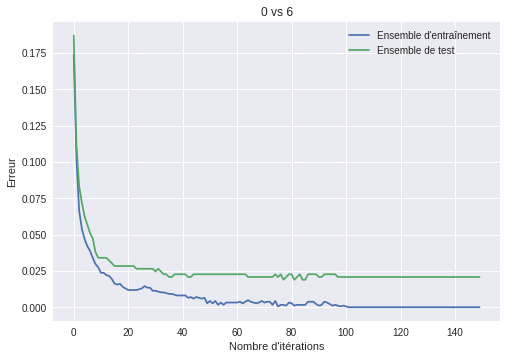

In [18]:
plt.figure()
model.errors(x06train, y06train, "Ensemble d'entraînement")
model.errors(x06test, y06test, "Ensemble de test")
plt.title("0 vs 6")
plt.legend()

Sur le graphe ci-dessus, on observe que l'erreur sur l'ensemble de test est décroissante. Elle devient constante à partir d'un certain nombre d'itérations, mais n'**augmente pas**. A ce titre, on peut dire que l'on **n'observe pas de surapprentissage** dans cette configuration

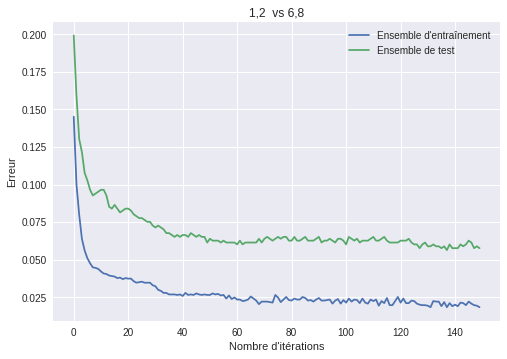

In [19]:
plt.figure()
model2.errors(xtrain, ytrain, "Ensemble d'entraînement")
model2.errors(xtest, ytest, "Ensemble de test")
plt.title("1,2  vs 6,8")
plt.legend()

Pour la configuration **1,2 vs. 6,8**, on observe une très légère croissance de l'erreur sur l'ensemble de test pour des itérations élevées.
Il y a un **risque de surapprentissage** dans ce cas.

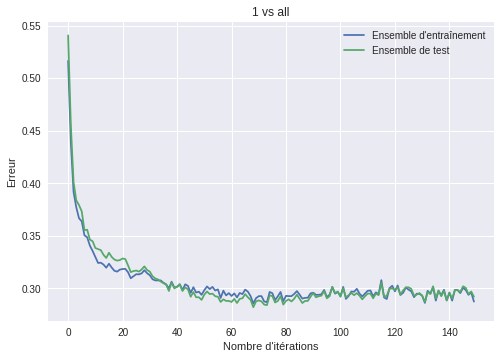

In [20]:
plt.figure()
model2.errors(x1alltrain, y1alltrain, "Ensemble d'entraînement")
model2.errors(x1alltest, y1alltest, "Ensemble de test")
plt.title("1 vs all")
plt.legend()

Pour cette dernière configuration, on n'observe pas non plus de  façon nette de surraprentissage.
On en conclut que le perceptron n'est pas particulièrement confronté aux problèmes de surraprentissage

# 3 Expressivité et feature map

## Question 3.1

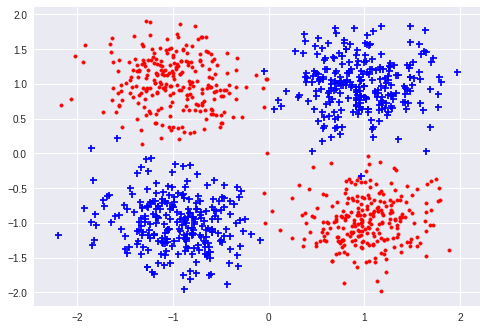

In [21]:
### Generation de donnees
xtrain,ytrain = gen_arti(data_type=1,epsilon=.2)
xtest,ytest = gen_arti(data_type=1,epsilon=.2)

plot_data(xtrain, ytrain)

plt.ion()


Cette nouvelle configuration simulée est plus complexe que la précédente.

Itérations de l'algorithme d'apprentissage ... 

0 [ 0.12754123]
20 [ 0.00037141]
40 [ 0.00035251]
60 [ 0.00022087]
80 [ 0.00054963]
100 [ 0.00054972]
120 [ 0.00025423]
140 [ 0.00035875]
160 [ 0.00060788]
180 [ 0.00052484]
200 [ 0.0006876]
220 [ 0.00046163]
240 [ 0.00022684]
260 [ 0.00032522]
280 [ 0.00039856]
300 [ 0.00058325]
320 [ 0.00044941]
340 [ 0.00044125]
360 [ 0.0002304]
380 [ 0.00045069]
400 [ 0.00041689]
420 [ 0.00043269]
440 [ 0.00039334]
460 [ 0.00034568]
480 [ 0.00053146]
score en train :  0.504
score en test :  0.497


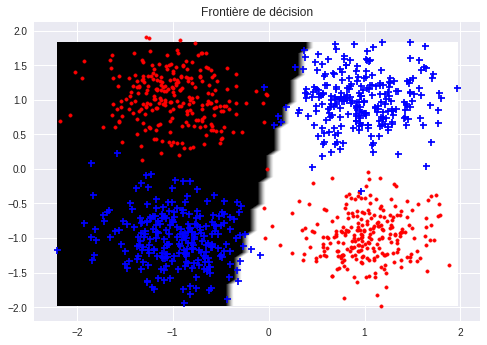

In [22]:
### Apprentissage
model= Perceptron(eps=1e-3, max_iter=500)
model.fit(xtrain,ytrain)
print("score en train : ",model.score(xtrain,ytrain))
print("score en test : ",model.score(xtest,ytest))
#### Tracer de frontiere
plt.figure()
plt.title("Frontière de décision")
plot_frontiere(xtrain,model.predict,50)
plot_data(xtrain,ytrain)

En effet, on remarque que la frontière ne peut pas être modélisée par une droite. Idéalement, il faudrait pouvoir faire "gagner en dimension" le perceptron.
Pour cela, nous allons implémenter plusieurs *feature maps* permettant de répondre à cette attente.

## Question 3.2 : Prolongement Polynomial

In [23]:
def poly(x):
    """Only works in 2D"""
    n, d = np.shape(x)
    assert(d == 2)
    res = np.ones((n, 6))
    res[:, 1:3] = x
    res[:, 3] = x[:, 0]*x[:, 1]
    res[:, 4:6] = x*x
    return res

In [24]:
print(poly(xtrain)[:3,:])

[[ 1.         -0.61488126  0.95669587 -0.58825437  0.37807897  0.91526699]
 [ 1.         -0.44807729  0.91264602 -0.40893596  0.20077326  0.83292275]
 [ 1.          0.46417118  1.1104017   0.51541647  0.21545488  1.23299194]]


Itérations de l'algorithme d'apprentissage ... 

0 [ 0.07879302]
20 [ 0.002706]
40 [ 0.00109906]
60 [ 0.00070913]
80 [ 0.00057238]
100 [ 0.00055975]
120 [ 0.00054867]
140 [ 0.00053981]
160 [ 0.00053421]
180 [ 0.00052839]
200 [ 0.00052449]
220 [ 0.00051746]
240 [ 0.00051106]
260 [ 0.00050732]
280 [ 0.00050392]
300 [ 0.00050033]
320 [ 0.00049821]
340 [ 0.00049604]
360 [ 0.0004918]
380 [ 0.00048861]
400 [ 0.0004867]
420 [ 0.00048377]
440 [ 0.00048099]
460 [ 0.00047734]
480 [ 0.00047427]
score en train :  0.994
score en test :  0.993


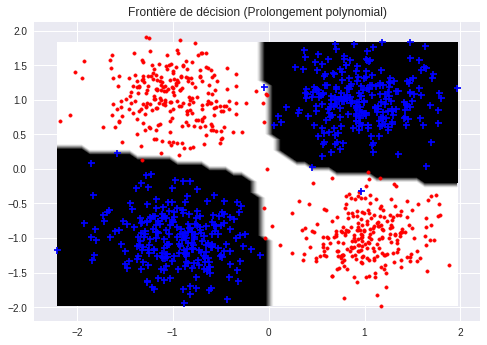

In [25]:
### Apprentissage
model= Perceptron(eps=1e-3, max_iter=500, projection=poly)
model.fit(xtrain,ytrain)
print("score en train : ",model.score(xtrain,ytrain))
print("score en test : ",model.score(xtest,ytest))
#### Tracer de frontiere
plt.figure()
plt.title("Frontière de décision (Prolongement polynomial)")
plot_frontiere(xtrain,model.predict,50)
plot_data(xtrain,ytrain)

En plongeant l'espace en dimension 5, on a pu augmenter l'expressivité de notre perceptron. Ainsi, la frontière obtenue modélise plus fidèlement la réalité.

## Question 3.3 : Plongement gaussien

La ième dimension dans l'espace projeté correspond à la probabilité d'observer $X=x$ si X suit une loi gaussienne de moyenne $o^i$ et de variance $\sigma$ à une facteur de normalisation près.

Les $o^i$ correspondent à $N_b$ gaussiennes. Une valeur très importante de $k(x, o^i)$ signifiera qu'il y a une forte probabilité que $x$ soit issue de la gaussienne de paramètres $(o^i, \sigma)$
**A COMPLETER**

In [26]:
def k(x, xp, sigma):
    xp = xp.reshape(-1)
    norm = np.linalg.norm(x - xp, axis=1)
    return np.exp(-norm*norm/(2*sigma**2))


def gauss(B, x, sigma=1):
    """Conventions
    B matrice de taille Nb*d
    x matrice de taille n*d"""
    nb, db = np.shape(B)
    nx, dx = np.shape(x)
    res = np.zeros((nx, nb))
    for i in range(nb):
        o = B[i, :]
        res[:, i] = k(x, o, sigma)
    return res

def B(x, nb=10, mode=1, sigma=1):
    nx, dx = np.shape(x)
    if mode==1: # Centres pris aléatoirement
        min_x, max_x = np.amin(x, axis=0), np.amax(x, axis=0)
        matb = np.random.rand(nb, dx)
        matb = (max_x-min_x)*matb + min_x
    
    else: # Centres pris dans la base d'apprentissage
        indices = range(nx)
        indices = np.random.permutation(indices)
        matb = x[indices[:nb],:] # Question: faut-il modifier x
    return matb


## Question 3.4